In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 43.2 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker
import pandas as pd
import botocore

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

In [3]:
s3 = boto3.resource('s3')



#role = sagemaker.get_execution_role()
# data_key1='train/0_0.xml'
#data_location1='s3://{}/{}'.format(bucket,data_key1)
#pd.read_xml(data_location1)
# s3.
bucket_name='sagemaker-us-east-845746890132'
bucket = s3.Bucket(bucket_name)
for obj in bucket.objects.all():
    path, filename = os.path.split(obj.key)
    if path and not os.path.exists(path):
        os.makedirs(path)
    try:
        bucket.download_file(obj.key, os.path.join(path, filename))
    except:
        print("ERROR: cannot upload path: " + obj.key)

In [4]:
classes = ['ship', 'iceberg']
categories = [
    {
        'class_id': 0,
        'name': 'ship'
    },
    {
        'class_id': 1,
        'name': 'iceberg'
    }
]

In [5]:
def extract_annotation(xml_file_path):
    
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['annotations'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['annotations'].append({
                     'class_id': class_id,
                     'left': xmin,
                     'top': ymin,
                     'width': xmax - xmin,
                     'height': ymax - ymin
                 })
    return annotation

In [6]:
extract_annotation("train75_xml/0_0.xml")

{'file': '0_0.png',
 'categories': [{'class_id': 0, 'name': 'ship'},
  {'class_id': 1, 'name': 'iceberg'}],
 'image_size': [{'width': 75, 'height': 75, 'depth': 3}],
 'annotations': [{'class_id': 0,
   'left': 31,
   'top': 26,
   'width': 8,
   'height': 20}]}

In [7]:

xml_files_training = [os.path.join("train75_xml", x) for x in os.listdir("train75_xml")]
xml_files_validation = [os.path.join("valid25_xml", x) for x in os.listdir("valid25_xml")]

In [8]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    print(image_file_path)
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 10)
    
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow')
        draw.text((0,0), classes[int(a['class_id'])], font=font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return plt

def show_random_annotations(plt):
    plt.figure(figsize=(16, 16))
    for i in range(0, 9):
        index = random.randint(0, len(xml_files_training) - 1)
        
        annot = extract_annotation(xml_files_training[index])
        image_file_path = os.path.join("train75_png", annot['file'])

        plt = plot_example(plt, annot, image_file_path, 3, 3, i)
    plt.show()

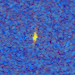

In [9]:
Image.open("train75_png/0_0.png")

{'file': '385_0.png', 'categories': [{'class_id': 0, 'name': 'ship'}, {'class_id': 1, 'name': 'iceberg'}], 'image_size': [{'width': 75, 'height': 75, 'depth': 3}], 'annotations': [{'class_id': 0, 'left': 22, 'top': 26, 'width': 28, 'height': 23}]}
train75_png/681_0.png
train75_png/1007_0.png
train75_png/130_1.png
train75_png/619_0.png
train75_png/136_0.png
train75_png/534_1.png
train75_png/85_1.png
train75_png/374_0.png
train75_png/805_1.png


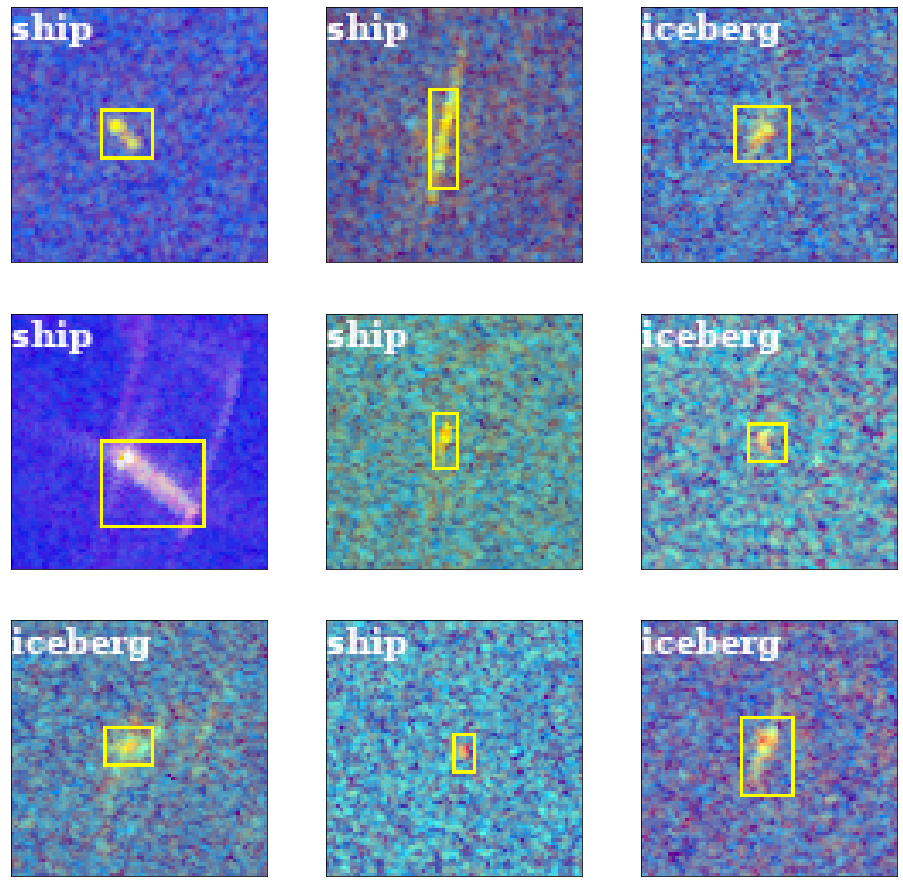

In [10]:
print(extract_annotation(xml_files_training[0]))
show_random_annotations(plt)

In [11]:
role = sagemaker.get_execution_role()
bucket_name = 'sagemaker-us-east-845746890132'
training_image = get_image_uri(boto3.Session().region_name, 'object-detection',
                              repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


In [12]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [13]:
print('Total examples:', len(xml_files_training))

Total examples: 1082


In [14]:
for xml_file in xml_files_training:
    target_set = 'train'
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join("train75_png", annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

for xml_file in xml_files_validation:
    target_set = 'validation'
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join("valid25_png", annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

In [15]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [16]:
print(len(train_annots), len(train_images))

1082 1082


In [17]:
for image in train_images:
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

In [18]:
%%time
sess = sagemaker.Session()

print('Uploading data..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

#upload test image
#upload test annotation


Uploading data..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 17.7 s, sys: 1.06 s, total: 18.8 s
Wall time: 2min 24s


In [19]:
s3_validation_annotation_path

's3://sagemaker-us-east-845746890132/validation_annotation'

In [20]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    #output_path='s3://sagemaker-us-east-845746890132/output',
    output_path='s3://' + bucket_name + '/output',
    sagemaker_session=sess
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [21]:
model= sagemaker.estimator.Estimator.attach(
    "object-detection-2020-07-15-18-59-25-058",
    sagemaker_session=sess

)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-07-15 20:19:56 Starting - Preparing the instances for training
2020-07-15 20:19:56 Downloading - Downloading input data
2020-07-15 20:19:56 Training - Training image download completed. Training in progress.
2020-07-15 20:19:56 Uploading - Uploading generated training model
2020-07-15 20:19:56 Completed - Training job completedDocker entrypoint called with argument(s): train
[07/15/2020 19:03:46 INFO 139787802048320] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective

In [22]:
#model.set_hyperparameters(
#    base_network='resnet-50',
#    early_stopping = True,
#    num_classes=2,
#   use_pretrained_model=1,
#   mini_batch_size=16,
#   epochs=40,
#    learning_rate=0.005,
#    lr_scheduler_step='10',
#    lr_scheduler_factor=0.1,
#    optimizer='sgd',
#    momentum=0.9,
#    weight_decay=0.001,
#    overlap_threshold=0.5,
#    nms_threshold=0.45,
#    image_shape=512,
#    num_training_samples=len(train_annots)
#)

In [23]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [24]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

In [25]:
#model.fit(inputs=data_channels, logs=True)

In [27]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: object-detection-2020-07-15-18-59-25-058


-----------------!
Model deployed!


In [30]:
#prediction validation (delete later)
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'png']
print(len(images))

361


In [31]:
#prediction test image
image_dir = 'test_png'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'png']
print(len(images))

161


In [32]:
deployed_model.content_type = 'image/png'

In [33]:
# index = 0
# print(images[index])
# image_path = os.path.join(image_dir, images[index])
tot = 0
cor = 0
for i, fname in enumerate(os.listdir(image_dir)):

    if (i % 10) == 0:
        print("-",end="")
    try:
        with open(os.path.join(image_dir, fname), 'rb') as f:
            b = bytearray(f.read())
    except Exception as e:
        continue
    tot += 1
#     print(i)
    results = deployed_model.predict(b)
    results = json.loads(results)

    preds = results['prediction']
#     print(preds[0][0])
    p = preds[0][0]
    name, _ = os.path.splitext(fname)
#     print(p, name[-1], name)
    if int(name[-1]) == int(p):
#         print("here")
        cor += 1
print(tot, cor)
print("accuracy: {}".format(cor/tot))

-----------------161 131
accuracy: 0.8136645962732919


In [34]:
# index = 0
# print(images[index])
# image_path = os.path.join(image_dir, images[index])

predictions = []
for i, fname in enumerate(os.listdir(image_dir)):

    if (i % 10) == 0:
        print("-",end="")
    try:
        with open(os.path.join(image_dir, fname), 'rb') as f:
            b = bytearray(f.read())
    except Exception as e:
        continue
    tot += 1
    results = deployed_model.predict(b)
    results = json.loads(results)

    preds = results['prediction']
    name, _ = os.path.splitext(fname)
#     print(preds[0][0])
    pred = preds[0][0]
    pred_proba = preds[0][1]
    
    predictions.append((int(name[-1]), int(pred), pred_proba, preds[0], os.path.join(image_dir, fname)))
    


-----------------

In [66]:
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score
y = list(map(lambda x: x[0], predictions))
y_pred = list(map(lambda x: x[1], predictions))
y_pred_proba = list(map(lambda x: x[2], predictions))
print("confusion matrix:\n", confusion_matrix(y, y_pred), sep='')
print("f1 score:", f1_score(y, y_pred, average='binary'))
print("accuracy:", accuracy_score(y, y_pred))

#print(predictions)
#print(predictions)
#print(len(list(filter(lambda x: x[0] == x[1], predictions)))/len(predictions))

confusion matrix:
[[65 21]
 [ 9 66]]
f1 score: 0.8148148148148148
accuracy: 0.8136645962732919


In [67]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, th = roc_curve(y, y_pred_proba)

print(auc(fpr, tpr))
#print(fpr)

0.5446511627906977


In [38]:
len(preds)

83

In [85]:
#failures
pred_fails = list(filter(lambda x: not (x[0] == x[1]), predictions))
len(pred_fails)
print ("idx: true pred confidence file")
for i,p in enumerate(pred_fails):
    print("{}: {} {} {} {}".format(i,p[0],p[1],p[2], p[4]))


idx: true pred confidence file
0: 0 1 0.5053348541259766 test_png/1323_0.png
1: 0 1 0.49105304479599 test_png/1582_0.png
2: 1 0 0.3781866133213043 test_png/801_1.png
3: 0 1 0.4909262955188751 test_png/1307_0.png
4: 0 1 0.652488112449646 test_png/561_0.png
5: 1 0 0.47460106015205383 test_png/1066_1.png
6: 0 1 0.3404254615306854 test_png/774_0.png
7: 1 0 0.20745296776294708 test_png/1420_1.png
8: 1 0 0.4067173898220062 test_png/1102_1.png
9: 0 1 0.753594160079956 test_png/1553_0.png
10: 0 1 0.42656078934669495 test_png/1523_0.png
11: 1 0 0.4874825179576874 test_png/547_1.png
12: 1 0 0.23411282896995544 test_png/292_1.png
13: 0 1 0.4950209856033325 test_png/372_0.png
14: 0 1 0.6783344745635986 test_png/1148_0.png
15: 0 1 0.6010724306106567 test_png/598_0.png
16: 0 1 0.35088789463043213 test_png/948_0.png
17: 1 0 0.3149816393852234 test_png/987_1.png
18: 0 1 0.5004585385322571 test_png/1319_0.png
19: 0 1 0.20133765041828156 test_png/1388_0.png
20: 0 1 0.4526631236076355 test_png/1053_0.png

In [86]:
#success
pred_success = list(filter(lambda x: x[0] == x[1], predictions))
len(pred_success)
print ("idx: true pred file")
for i,p in enumerate(pred_success):
    print("{}: {} {} {} {}".format(i,p[0],p[1],p[4],p[2]))

idx: true pred file
0: 1 1 test_png/223_1.png 0.5270087718963623
1: 0 0 test_png/966_0.png 0.9163430333137512
2: 0 0 test_png/693_0.png 0.8358211517333984
3: 1 1 test_png/426_1.png 0.5288788676261902
4: 0 0 test_png/1316_0.png 0.8902795314788818
5: 1 1 test_png/353_1.png 0.7726503610610962
6: 0 0 test_png/1038_0.png 0.9534990191459656
7: 1 1 test_png/53_1.png 0.4781859219074249
8: 0 0 test_png/30_0.png 0.43215954303741455
9: 1 1 test_png/841_1.png 0.6951874494552612
10: 1 1 test_png/635_1.png 0.5422487258911133
11: 1 1 test_png/231_1.png 0.8545064926147461
12: 1 1 test_png/936_1.png 0.5048280954360962
13: 0 0 test_png/929_0.png 0.7777577638626099
14: 1 1 test_png/1302_1.png 0.31827297806739807
15: 1 1 test_png/1373_1.png 0.8168606162071228
16: 1 1 test_png/703_1.png 0.7557420134544373
17: 1 1 test_png/1194_1.png 0.1516711413860321
18: 1 1 test_png/1335_1.png 0.44617411494255066
19: 0 0 test_png/194_0.png 0.9058738350868225
20: 1 1 test_png/962_1.png 0.6908305287361145
21: 1 1 test_png/

test_png/553_1.png


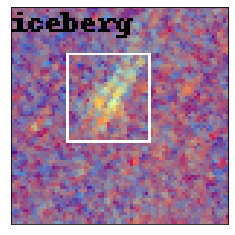

In [94]:
ps = pred_success
#ps = pred_fails
idx = 79
image_path = ps[idx][4]
print(image_path)
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 10)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = ps[idx][3]
    
    box = [w*xmin, h*ymin, w*xmax, h*ymax]
    draw.rectangle(box, outline='white', width=1)
    draw.text((0, 0), classes[int(class_id)], fill='#000000')

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

test_png/1466_0.png


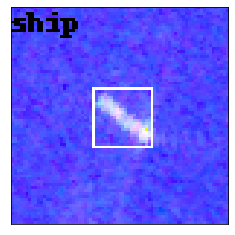

In [87]:
ps = pred_success
#ps = pred_fails
idx = 100
image_path = ps[idx][4]
print(image_path)
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 10)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = ps[idx][3]
    
    box = [w*xmin, h*ymin, w*xmax, h*ymax]
    draw.rectangle(box, outline='white', width=1)
    draw.text((0, 0), classes[int(class_id)], fill='#000000')

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

test_png/389_1.png


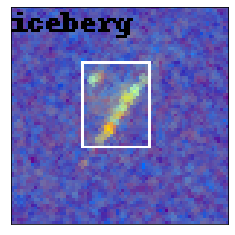

In [88]:
ps = pred_success
#ps = pred_fails
idx = 101
image_path = ps[idx][4]
print(image_path)
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 10)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = ps[idx][3]
    
    box = [w*xmin, h*ymin, w*xmax, h*ymax]
    draw.rectangle(box, outline='white', width=1)
    draw.text((0, 0), classes[int(class_id)], fill='#000000')

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

test_png/561_0.png


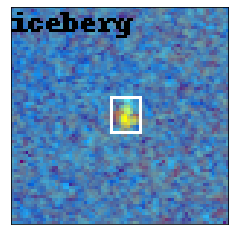

In [78]:
#ps = pred_success
ps = pred_fails
idx = 4
image_path = ps[idx][4]
print(image_path)
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 10)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = ps[idx][3]
    
    box = [w*xmin, h*ymin, w*xmax, h*ymax]
    draw.rectangle(box, outline='white', width=1)
    draw.text((0, 0), classes[int(class_id)], fill='#000000')

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

test_png/1553_0.png


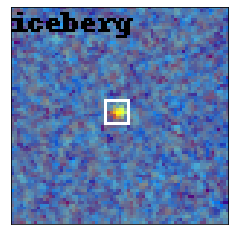

In [89]:
#ps = pred_success
ps = pred_fails
idx = 9
image_path = ps[idx][4]
print(image_path)
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 10)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = ps[idx][3]
    
    box = [w*xmin, h*ymin, w*xmax, h*ymax]
    draw.rectangle(box, outline='white', width=1)
    draw.text((0, 0), classes[int(class_id)], fill='#000000')

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

test_png/60_1.png


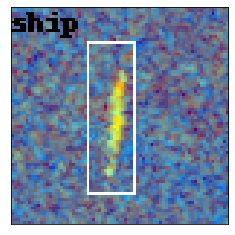

In [90]:
#ps = pred_success
ps = pred_fails
idx = 26
image_path = ps[idx][4]
print(image_path)
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 10)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = ps[idx][3]
    
    box = [w*xmin, h*ymin, w*xmax, h*ymax]
    draw.rectangle(box, outline='white', width=1)
    draw.text((0, 0), classes[int(class_id)], fill='#000000')

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

In [2]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

NameError: name 'sagemaker' is not defined

In [ ]:
#result should be below
pred
1 class : ship

2 0.08 (0.5)
3
4
5
6
